# Day 3b
In this notebook, we will continue with tweet bias classification but using feature extraction instead of zero-/few-shot learning. This makes sense in situations where you have more labelled training data and want to achieve better performance. We will use the `SentenceTransformer` library to extract features from the text, and then use a `RidgeClassifierCV` to classify the tweets. We will train the classifier on some additional training data (`media_bias_train`) and evaluate it on the same data as day_3a (`media_bias_test`).

## Environment Setup

In [1]:
import sys
if 'google.colab' in sys.modules:  # If in Google Colab environment
    # Mount google drive to enable access to data files
    from google.colab import drive
    drive.mount('/content/drive')
    
    # Install requisite packages
    !pip install sentence_transformers &> /dev/null

    # Change working directory to day_3
    %cd /content/drive/MyDrive/LLM4BeSci_GSERM2024/day_3

In [2]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifierCV
import seaborn as sns

## Feature Extraction
The code begins by loading the data as `pandas.DataFrame` objects.

In [3]:
# Reload test data from last last notebook (day_3a.ipynb)
media_bias_test = pd.read_csv('media_bias_test.csv')

# Load training data
media_bias_train = pd.read_csv('media_bias_train.csv')
media_bias_train

,author,text,bias,type,audience
0,Mark Pocan (Representative from Wisconsin),Excited to join @fairvote today @NYUWashington...,neutral,policy,national
1,Ileana Ros-Lehtinen (Representative from Florida),Placer reunirme c la directora de @NTN24 @CGur...,neutral,media,national
2,George Miller (Representative from California),DID YOU KNOW: 73% of Americans want to #RaiseT...,neutral,policy,national
3,John Boehner (Representative from Ohio),.@meridianstar: http://t.co/gyjLbggc0t @GreggH...,neutral,policy,national
4,Richard Burr (Senator from North Carolina),".@AmericanLegion, @IAVA, @AMVETSNational, and ...",neutral,support,national
...,...,...,...,...,...
1195,Lamar Alexander (Senator from Tennessee),ÛÏPpl of faith shouldnÛªt have their govt te...,partisan,policy,national
1196,Steve Pearce (Representative from New Mexico),Great work to all the firefighters and officia...,partisan,support,constituency
1197,Bernard Sanders (Senator from Vermont),Happening now: Sen. Sanders is on #MSNBC talki...,partisan,policy,national
1198,Amy Klobuchar (Senator from Minnesota),Calling for hearing after recent train derailm...,partisan,policy,national


Note the considerable increase in the number of training samples. The code then next initializes the `SentenceTransformer` model `'all-mpnet-base-v2'` and extracts features from the training data using the `encode` method. 

In [4]:
# Initialize feature extraction pipeline
model = SentenceTransformer('all-mpnet-base-v2')

# Extract features
train_features = model.encode(media_bias_train['text'])
train_features

array([[-0.0503746 ,  0.06582697,  0.00388487, ...,  0.01817725,
         0.02201664, -0.03550809],
       [-0.04547264,  0.05585405, -0.01646715, ..., -0.02260329,
        -0.07527739, -0.00351911],
       [-0.07689207,  0.10214937,  0.00859927, ..., -0.01990304,
        -0.04055693, -0.00848057],
       ...,
       [-0.03208775,  0.05266211,  0.0408248 , ..., -0.02403262,
         0.01348685, -0.04189523],
       [-0.05233982,  0.13784754, -0.01113208, ...,  0.01583433,
        -0.0646306 , -0.00388265],
       [-0.06097319,  0.07792741, -0.03723459, ...,  0.00800201,
        -0.02155517,  0.04147355]], dtype=float32)


The features are then standardised before being fed into `RidgeClassifierCV`. This is crucial, since `RidgeClassifierCV` uses l2 (ridge) regularisation to prevent over-fitting, which assumes that the features are standardised. The classifier is then trained on the training data using the `fit` method. Note that `RidgeClassifierCV` will automatically perform cross-validation on the training data to find the best alpha value from the list of `alphas` provided. Performance on the training data is then evaluated using the `score` method.

In [5]:
# Standardize features
scaler = StandardScaler()
scaler.fit(train_features)
features = scaler.transform(train_features)

# Initialize classifier
ridge = RidgeClassifierCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10, 100])

# Train classifier
ridge.fit(train_features, media_bias_train['bias'])
f"Train accuracy: {ridge.score(train_features, media_bias_train['bias'])}"

'Train accuracy: 0.775'

Features are next extracted for the test set and standardised using the same `StandardScaler` object that was fitted on the training data to prevent data leakage. The classifier is then evaluated on the test data using the `score` method.

In [6]:
# Extract features for test set
test_features = model.encode(media_bias_test['text'])

# Standardising features
test_features = scaler.transform(test_features)

# Test classifier
f"Test accuracy: {ridge.score(test_features, media_bias_test['bias'])}"

'Test accuracy: 0.75'

As you can see, the feature extraction method performs better than both zero-shot and few-shot classification from the last notebook. Why do you think this is? 

We can also visualize the confusion matrix:

<Axes: xlabel='col_0', ylabel='bias'>

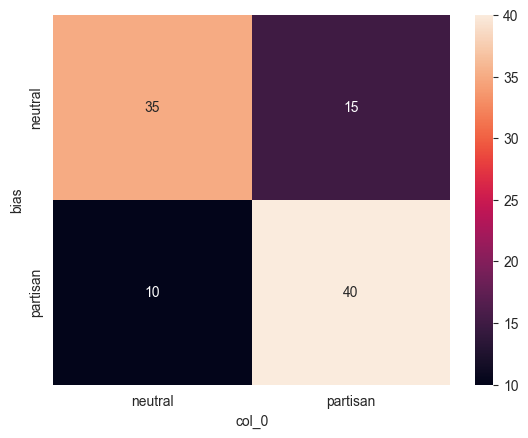

In [7]:
# Confusion matrix
confusion = pd.crosstab(media_bias_test['bias'], ridge.predict(test_features))
sns.heatmap(confusion, annot=True)

Compared to zero-shot and few-shot classification, the false positive to false negative ratio is much more equal in this case, meaning that the classifier is more balanced in its predictions.

**TASK 1:** Go to the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard) and find a well-performing small model (i.e., high in the leaderboard, <1 billion parameters). Open the model card by clicking on the model, test whether the model can be run with `sentence-transformers` (by looking at the tags under the model name: there should be tag called `sentence-transformers`). Replace the `"all-mpnet-base-v2"` in the code above and re-run the analysis. Does the performance improve? 
**TASK 2:** Try other similar models and compare. 